In [1]:
import os
import pandas as pd
import requests
from io import BytesIO
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import numpy as np
from tqdm import tqdm


In [2]:
s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))

def download_image_from_s3(image_url, download_path):
    # Extract the bucket name and key from the image_url
    bucket_name = image_url.split('/')[2]
    key = '/'.join(image_url.split('/')[3:])
    
    # Download the image
    s3_client.download_file(bucket_name, key, download_path)
    # print(f"Image downloaded to {download_path}")


In [3]:
def download_image(s3_client, path, filename):
    bucket_name = path.split('/')[2]
    key = '/'.join(path.split('/')[3:]) + filename
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    return mpimg.imread(BytesIO(response["Body"].read()), format="tiff")

def normalize(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

def get_image_from_well(s3_client, load_data_well):
    channel_paths = {
        "AGP": load_data_well['PathName_OrigAGP'].values[0],
        "DNA": load_data_well['PathName_OrigDNA'].values[0],
        "ER": load_data_well['PathName_OrigER'].values[0],
        "Mito": load_data_well['PathName_OrigMito'].values[0],
        "RNA": load_data_well['PathName_OrigRNA'].values[0]
    }

    channel_files = {
        "AGP": load_data_well['FileName_OrigAGP'].values[0],
        "DNA": load_data_well['FileName_OrigDNA'].values[0],
        "ER": load_data_well['FileName_OrigER'].values[0],
        "Mito": load_data_well['FileName_OrigMito'].values[0],
        "RNA": load_data_well['FileName_OrigRNA'].values[0]
    }

    # Download and normalize each channel
    images = {}
    for channel, path in channel_paths.items():
        filename = channel_files[channel]
        images[channel] = download_image(s3_client, path, filename)
        # Normalize the image to [0, 1]
        images[channel] = normalize(images[channel])

    # Combine the channels into an RGB image
    combined_image = np.zeros((images["DNA"].shape[0], images["DNA"].shape[1], 3))

    # Map each channel to RGB (example mapping)
    combined_image[..., 0] = images["DNA"]  # Red channel
    combined_image[..., 1] = images["AGP"]  # Green channel
    combined_image[..., 2] = images["ER"]  # Blue channel

    return combined_image


In [4]:
profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/load_data_csv/"
    "{Metadata_Batch}/{Metadata_Plate}/load_data_with_illum.parquet"
)

GIT_CLONE_DIR = "./"

plates = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/plate.csv.gz"))
wells = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/well.csv.gz"))
compounds = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/compound.csv.gz"))

In [102]:
# Whether to sample a certain number of wells per chemical
sample_from_group = True
sample_number = 2

# Whether to use all chemicals or specific ones 
all_chemicals = False


In [108]:
# Get plates with compounds
compound_plates = plates[plates['Metadata_PlateType'] == 'COMPOUND']
compound_plates_with_wells = compound_plates.merge(wells, on=['Metadata_Source', 'Metadata_Plate'])
wells_with_chems = compound_plates_with_wells.merge(compounds, on="Metadata_JCP2022")

# Get rid of NA 
selected_chemicals = wells_with_chems['Metadata_InChIKey'].dropna().unique()
wells_with_chems = wells_with_chems[wells_with_chems['Metadata_InChIKey'].isin(selected_chemicals)]

# Get chemical counts and dataframe with only > counts
wells_per_chemical = wells_with_chems['Metadata_InChIKey'].value_counts().reset_index()
    # CRITERIA FOR WHICH CHEMICALS TO USE
if all_chemicals:
    valid_chemicals = selected_chemicals
else:
    valid_chemicals = wells_per_chemical[(wells_per_chemical['count'] > 15) & (wells_per_chemical['count'] < 17)]['Metadata_InChIKey']

print("Number of valid chemicals : ", len(valid_chemicals))
valid_wells = wells_with_chems[wells_with_chems['Metadata_InChIKey'].isin(valid_chemicals)]
print(len(valid_wells))
if sample_from_group:
    valid_wells = valid_wells.groupby(['Metadata_InChIKey'], group_keys=False).apply(lambda x: x.sample(sample_number))
    print(len(valid_wells))

Number of valid chemicals :  79
1264
158


/tmp/ipykernel_470696/3506562127.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_wells = valid_wells.groupby(['Metadata_InChIKey'], group_keys=False).apply(lambda x: x.sample(sample_number))


In [109]:
# Get plates we need to load : 
relevant_plates = valid_wells['Metadata_Plate'].unique()
print("Number of plates : ", len(relevant_plates))

# Load data for plates
load_data = []
for plate in tqdm(relevant_plates):
    # print(plate)
    rows = compound_plates[compound_plates['Metadata_Plate'] == plate]
    row = compound_plates[compound_plates['Metadata_Plate'] == plate].iloc[0]
    s3_path = loaddata_formatter.format(**row.to_dict())
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
load_data = pd.concat(load_data)

Number of plates :  125


 45%|████▍     | 56/125 [00:38<00:45,  1.53it/s]

In [93]:
compound_plates = plates[plates['Metadata_PlateType'] == 'COMPOUND']
compound_plates_with_wells = compound_plates.merge(wells, on=['Metadata_Source', 'Metadata_Plate'])

metadata = compound_plates_with_wells.merge(compounds, on="Metadata_JCP2022")
selected_chemicals = metadata['Metadata_InChIKey'].dropna().unique()
# selected_chemicals = np.random.choice(selected_chemicals, 2000, replace=False)
print("Selected chemicals length : ", len(selected_chemicals))

metadata = metadata[metadata['Metadata_InChIKey'].isin(selected_chemicals)]
wells_per_chemical = metadata['Metadata_InChIKey'].value_counts().reset_index()

# Only get chemicals with a count of > 100
valid_chemicals = wells_per_chemical[wells_per_chemical['count'] > 100]['Metadata_InChIKey']
metadata = metadata[metadata['Metadata_InChIKey'].isin(valid_chemicals)]

print(metadata)

grouped_metadata = metadata.groupby(['Metadata_InChIKey'], group_keys=False).apply(lambda x: x.sample(2))
# grouped_metadata = metadata.groupby(['Metadata_InChIKey'], group_keys=False).apply(lambda x: x.sample(10))
# groupe_metadat = metadata.groupby(['Metadata_InChIKey', 'Metadata_Source'], group_keys=False).apply(lambda x: x.sample(1))
print("Number of chemicals : ", len(grouped_metadata['Metadata_InChIKey']))

relevant_plates = grouped_metadata['Metadata_Plate'].unique()
print("Number of relevant plates : ", len(relevant_plates))

Selected chemicals length :  115730
       Metadata_Source   Metadata_Batch Metadata_Plate Metadata_PlateType  \
0             source_1  Batch1_20221004       UL001641           COMPOUND   
1             source_1  Batch1_20221004       UL001641           COMPOUND   
2             source_1  Batch1_20221004       UL001641           COMPOUND   
43            source_1  Batch1_20221004       UL001641           COMPOUND   
44            source_1  Batch1_20221004       UL001641           COMPOUND   
...                ...              ...            ...                ...   
819691        source_9   20211103-Run16     GR00004421           COMPOUND   
819692        source_9   20211103-Run16     GR00004421           COMPOUND   
819693        source_9   20211103-Run16     GR00004421           COMPOUND   
819714        source_9   20211103-Run16     GR00004421           COMPOUND   
819715        source_9   20211103-Run16     GR00004421           COMPOUND   

       Metadata_Well Metadata_JCP2022  

/tmp/ipykernel_470696/4100864413.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_metadata = metadata.groupby(['Metadata_InChIKey'], group_keys=False).apply(lambda x: x.sample(2))


In [7]:
load_data = []
for plate in tqdm(relevant_plates):
    row = compound_plates[compound_plates['Metadata_Plate'] == plate].iloc[0]
    s3_path = loaddata_formatter.format(**row.to_dict())
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
load_data = pd.concat(load_data)


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


In [17]:

wells_per_chemical_grouped = grouped_metadata['Metadata_InChIKey'].value_counts().reset_index()

# selected_inchikey = 'IHLVSLOZUHKNMQ-UHFFFAOYSA-N'
unique_inchikeys = metadata['Metadata_InChIKey'].dropna().unique()
# selected_inchikeys = np.random.choice(unique_inchikeys, 10, replace=False)
selected_inchikeys = unique_inchikeys

# filtered metadata for one chemical
filtered_metadata = grouped_metadata[grouped_metadata['Metadata_InChIKey'].isin(selected_inchikeys)]
# filtered_metadata = grouped_metadata[grouped_metadata['Metadata_InChIKey'] == selected_inchikey]
# print("FILTERED METADATA : ", filtered_metadata

# 
random_well = filtered_metadata.sample(5).iloc[0]
print("RANDOM WELL : ", random_well)

load_data_well = load_data[(load_data['Metadata_Source'] == random_well['Metadata_Source']) &
                                    (load_data['Metadata_Well'] == random_well['Metadata_Well'])]


image_url = os.path.join(load_data_well['PathName_OrigDNA'].values[0], load_data_well['FileName_OrigDNA'].values[0])

RANDOM WELL :  Metadata_Source                                                source_9
Metadata_Batch                                            20210901_Run8
Metadata_Plate                                               GR00003313
Metadata_PlateType                                             COMPOUND
Metadata_Well                                                       M01
Metadata_JCP2022                                         JCP2022_033954
Metadata_InChIKey                           IBCXZJCWDGCXQT-UHFFFAOYSA-N
Metadata_InChI        InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...
Name: 702434, dtype: object


In [23]:
len(filtered_metadata)
filtered_metadata

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
385803,source_3,CP_36_all_Phenix1,BAY5875b,COMPOUND,H01,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...
209567,source_11,Batch5,EC000076,COMPOUND,H01,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...
555168,source_7,20210723_Run2,CP2-SC1-05,COMPOUND,K01,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...
420815,source_5,JUMPCPE-20210730-Run14_20210731_000211,ATSJUM209,COMPOUND,K01,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...
487696,source_6,p210920CPU2OS48hw384exp028JUMP,110000296354,COMPOUND,N23,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
467226,source_6,p210830CPU2OS48hw384exp023JUMP,110000293091,COMPOUND,H20,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
761876,source_9,20211013-Run14,GR00003279,COMPOUND,E25,JCP2022_033954,IBCXZJCWDGCXQT-UHFFFAOYSA-N,InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...
702434,source_9,20210901_Run8,GR00003313,COMPOUND,M01,JCP2022_033954,IBCXZJCWDGCXQT-UHFFFAOYSA-N,InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...
622123,source_8,J2,A1170470,COMPOUND,A24,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...
76091,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152634,COMPOUND,E01,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...


In [11]:
print(load_data)

     Metadata_Source Metadata_Batch Metadata_Plate Metadata_Well  \
0           source_7  20210803_Run5     CP5-SC1-19           A01   
1           source_7  20210803_Run5     CP5-SC1-19           A01   
2           source_7  20210803_Run5     CP5-SC1-19           A01   
3           source_7  20210803_Run5     CP5-SC1-19           A01   
4           source_7  20210803_Run5     CP5-SC1-19           A01   
...              ...            ...            ...           ...   
3451        source_8             J1       A1170411           P24   
3452        source_8             J1       A1170411           P24   
3453        source_8             J1       A1170411           P24   
3454        source_8             J1       A1170411           P24   
3455        source_8             J1       A1170411           P24   

     Metadata_Site        FileName_IllumAGP        FileName_IllumDNA  \
0                0  CP5-SC1-19_IllumAGP.npy  CP5-SC1-19_IllumDNA.npy   
1                1  CP5-SC1-19_IllumAGP

In [27]:
for chemical in unique_inchikeys:
    filtered_df_chemicals = filtered_metadata[filtered_metadata['Metadata_InChIKey'] == chemical]


    merged_df = pd.merge(
    filtered_df_chemicals,
    load_data,
    on=['Metadata_Source', 'Metadata_Well'],
    # on=['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'],
    how='inner'
    )


merged_df.columns
merged_df['Metadata_Site']

    # load_data_wells = load_data[(load_data['Metadata_Source'] == random_well['Metadata_Source']) &
    #                                 (load_data['Metadata_Well'] == random_well['Metadata_Well'])]


0    1
1    2
2    3
3    4
4    1
5    2
6    3
7    4
Name: Metadata_Site, dtype: object

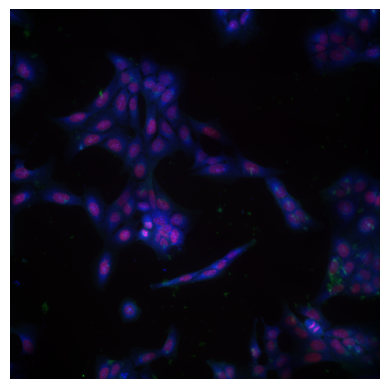

In [9]:
combined_image = get_image_from_well(s3_client, load_data_well)

# Visualize the combined image
plt.imshow(combined_image)
plt.axis('off')  # Hide the axes
plt.show()
# plt.imsave("combined_image.png", image, cmap="gray")

In [10]:
left = 0
upper = 0
right = 696
left = 520

img = Image.open(imagepath)
cropped_img = img.crop((left, upper, right, lower))



NameError: name 'Image' is not defined